In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
from PIL import Image
import os
import sys
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import imageio
from google.colab import files
import tensorflow.contrib.eager as tfe
import IPython.display
import time
import functools


In [0]:
tf.enable_eager_execution()
print("execution : {}".format(tf.executing_eagerly()))

execution : True


In [0]:
uploaded = files.upload()

Saving content.jpeg to content (7).jpeg
Saving style.jpg to style (7).jpg


In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

(200, 412, 3)
(1, 200, 412, 3)


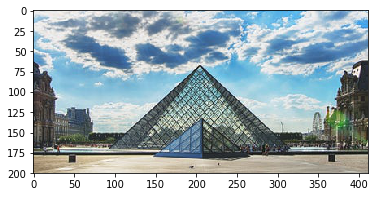

In [0]:
content = imageio.imread("content.jpeg")
imshow(content)
print(content.shape)
content = np.resize(content,(1,content.shape[0],content.shape[1],content.shape[2]))
print(content.shape)
content = tf.keras.applications.vgg19.preprocess_input(content)

(833, 1000, 3)
(1, 833, 1000, 3)


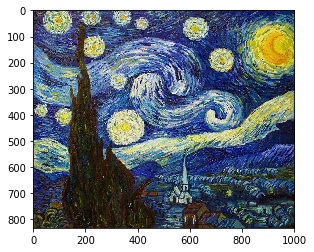

In [0]:
style = imageio.imread("style.jpg")
imshow(style)
print(style.shape)
style = np.resize(style,(1,style.shape[0],style.shape[1],style.shape[2]))
print(style.shape)
style = tf.keras.applications.vgg19.preprocess_input(style)

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

nc = len(content_layers)
ns = len(style_layers)

In [0]:
def vggmodel():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  
  return models.Model(vgg.input, model_outputs)

In [0]:
def content_loss(a_g, a_c):
  content_loss = tf.reduce_mean(tf.square(a_g - a_c))
  return content_loss

In [0]:
def gram_matrix(a):
  channels = int(a.shape[-1])
  a = tf.reshape(a, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  gram = gram / tf.cast(n, tf.float32)
  return gram

In [0]:
def style_loss(a_g, a_s):
  height, width, channels = a_g.get_shape().as_list()
  gram_style = gram_matrix(a_g)
  gram_target = gram_matrix(a_s)
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [0]:
def activations_layers(model, content, style):
  
  so = model(style)
  co = model(content)
  
  style_activations = [slayer[0] for slayer in so[:ns]]
  content_activations = [clayer[0] for clayer in co[ns:]]
  return style_activations, content_activations

In [0]:
def total_loss(model, loss_weights, init_image, style_activations, content_activations):
  
  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)
  
  so = model_outputs[:ns]
  co = model_outputs[ns:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(ns)
  for target_style, comb_style in zip(style_activations, so):
    style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)
    
  
  weight_per_content_layer = 1.0 / float(nc)
  for target_content, comb_content in zip(content_activations, co):
    content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def ocmpute_grads(data):
  with tf.GradientTape() as tape: 
    all_loss = total_loss(**data)
  
  tl = all_loss[0]
  return tape.gradient(tl, data['init_image']), all_loss

In [0]:
import IPython.display

def final_transfer(content, style, iterations=1000, content_weight=1e3, style_weight=1e-2): 
  
  model = vggmodel() 
  for layer in model.layers:
    layer.trainable = False
  
  
  style_activations, content_activations = activations_layers(model, content, style)
  init_image = tfe.Variable(content, dtype=tf.float32)
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  iter_count = 1
  best_loss, best_img = float('inf'), None  
  loss_weights = (style_weight, content_weight)
  data = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'style_activations': style_activations,
      'content_activations': content_activations
  }  
  imgs = []
  for i in range(iterations):
    grads, all_loss = compute_grads(data)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    if i % 100 == 0:
      #start_time = time.time()
      
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '.format(loss, style_score, content_score))
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(5,5,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
 

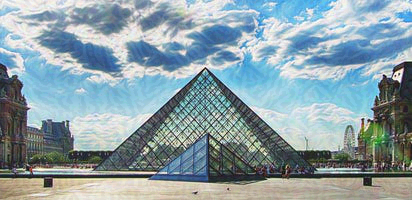

Iteration: 0
Total loss: 1.9079e+08, style loss: 1.9079e+08, content loss: 0.0000e+00, 


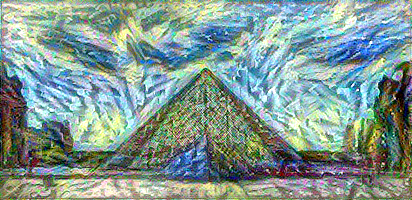

Iteration: 100
Total loss: 5.4740e+06, style loss: 3.4981e+06, content loss: 1.9758e+06, 


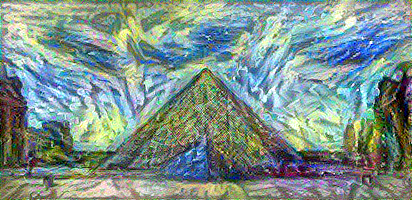

Iteration: 200
Total loss: 2.8293e+06, style loss: 1.5211e+06, content loss: 1.3082e+06, 


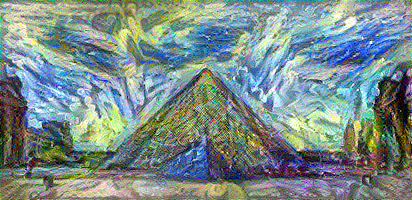

Iteration: 300
Total loss: 1.9042e+06, style loss: 9.3192e+05, content loss: 9.7229e+05, 


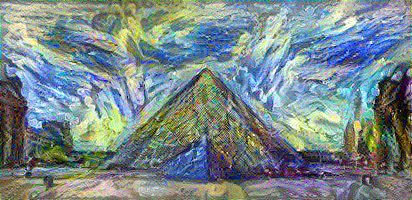

Iteration: 400
Total loss: 1.4685e+06, style loss: 6.8750e+05, content loss: 7.8101e+05, 


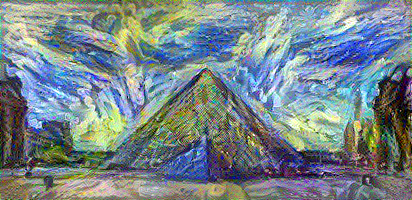

Iteration: 500
Total loss: 1.2387e+06, style loss: 5.6959e+05, content loss: 6.6915e+05, 


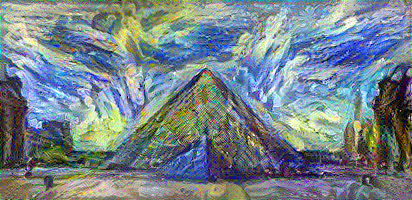

Iteration: 600
Total loss: 1.1037e+06, style loss: 4.9973e+05, content loss: 6.0394e+05, 


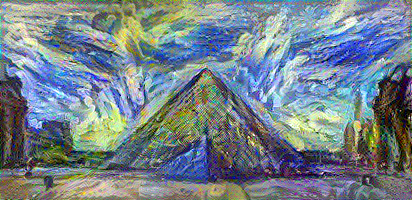

Iteration: 700
Total loss: 1.0142e+06, style loss: 4.5657e+05, content loss: 5.5764e+05, 


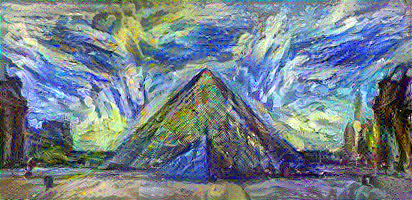

Iteration: 800
Total loss: 9.5245e+05, style loss: 4.2764e+05, content loss: 5.2481e+05, 


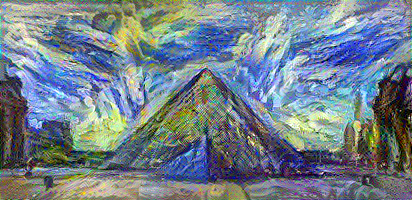

Iteration: 900
Total loss: 9.0823e+05, style loss: 4.0695e+05, content loss: 5.0129e+05, 


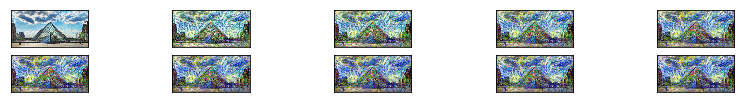

In [0]:
final_transfer(content, style, iterations=1000)

In [0]:
uploaded = files.upload()

Saving test2.jpg to test2.jpg


(259, 195, 3)
(1, 259, 195, 3)


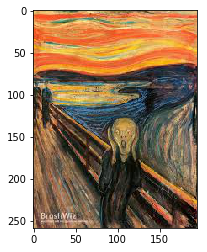

In [0]:
test = imageio.imread("test2.jpg")
imshow(test)
print(test.shape)
test = np.resize(test,(1,test.shape[0],test.shape[1],test.shape[2]))
print(test.shape)
test = tf.keras.applications.vgg19.preprocess_input(test)

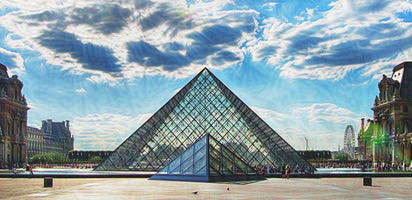

Iteration: 0
Total loss: 2.7653e+08, style loss: 2.7653e+08, content loss: 0.0000e+00, 


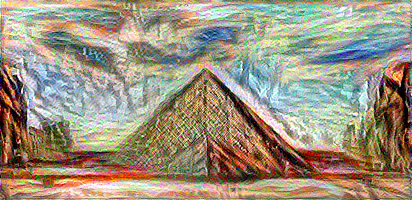

Iteration: 100
Total loss: 1.0122e+07, style loss: 7.3649e+06, content loss: 2.7568e+06, 


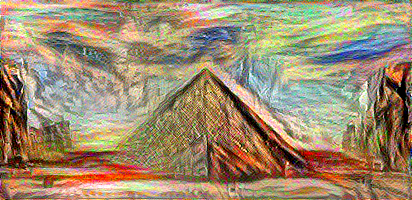

Iteration: 200
Total loss: 5.2334e+06, style loss: 3.0946e+06, content loss: 2.1388e+06, 


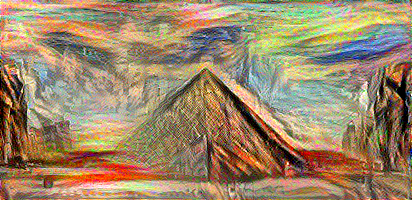

Iteration: 300
Total loss: 3.4970e+06, style loss: 1.7899e+06, content loss: 1.7071e+06, 


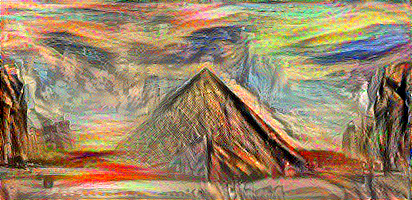

Iteration: 400
Total loss: 2.7341e+06, style loss: 1.3033e+06, content loss: 1.4308e+06, 


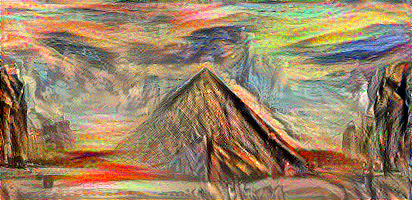

Iteration: 500
Total loss: 2.3492e+06, style loss: 1.0737e+06, content loss: 1.2755e+06, 


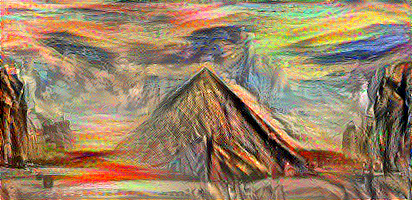

Iteration: 600
Total loss: 2.1248e+06, style loss: 9.4564e+05, content loss: 1.1792e+06, 


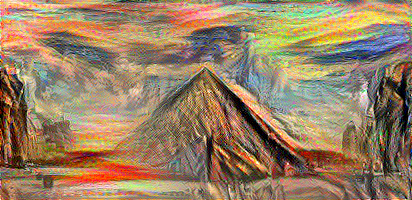

Iteration: 700
Total loss: 1.9773e+06, style loss: 8.7255e+05, content loss: 1.1047e+06, 


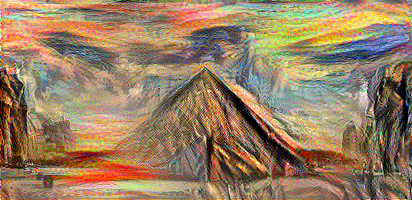

Iteration: 800
Total loss: 1.8729e+06, style loss: 8.2313e+05, content loss: 1.0498e+06, 


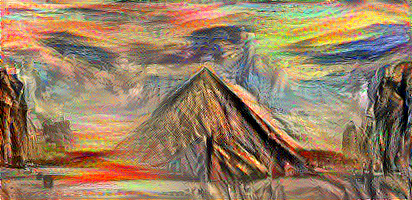

Iteration: 900
Total loss: 1.7975e+06, style loss: 7.8828e+05, content loss: 1.0093e+06, 


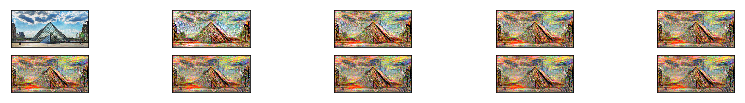

In [0]:
final_transfer(content, test, iterations=1000)